# Implementação do modelo LSTM

Implementar modelo LSTM para predição de subidas.

Problema: De acordo com as 10 últimos valores de fechamento, o próximo valor irá subir ou descer?

Entradas: close das 10 ultimas operações

Saída: Subiu

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_frame = pd.read_csv("/content/drive/MyDrive/9P/DSC/datasets/WINN_M1.csv",sep='\t')

In [6]:
data_frame.head()

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
0,2020.10.15,11:49:00,98565,98575,98530,98575,2373,9001,5
1,2020.10.15,11:50:00,98570,98625,98570,98600,5483,19111,5
2,2020.10.15,11:51:00,98595,98600,98535,98580,4572,17663,5
3,2020.10.15,11:52:00,98575,98620,98535,98615,3536,13143,5
4,2020.10.15,11:53:00,98620,98625,98575,98610,3729,13702,5


In [7]:
data_frame.loc[lambda data_frame1: (data_frame['<OPEN>'] - data_frame['<CLOSE>']) > 10, "Subiu"] = 0
data_frame.loc[lambda data_frame1: (data_frame['<CLOSE>'] - data_frame['<OPEN>']) > 10, "Subiu"] = 1
data_frame.loc[lambda data_frame1: ((data_frame['<OPEN>'] >= data_frame['<CLOSE>'] - 10) & (data_frame['<OPEN>'] <= (data_frame['<CLOSE>'] + 10))), "Subiu"] = 2
data_frame.head()

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>,Subiu
0,2020.10.15,11:49:00,98565,98575,98530,98575,2373,9001,5,2.0
1,2020.10.15,11:50:00,98570,98625,98570,98600,5483,19111,5,1.0
2,2020.10.15,11:51:00,98595,98600,98535,98580,4572,17663,5,0.0
3,2020.10.15,11:52:00,98575,98620,98535,98615,3536,13143,5,1.0
4,2020.10.15,11:53:00,98620,98625,98575,98610,3729,13702,5,2.0


In [8]:
data_frame.loc[lambda data_frame: data_frame['Subiu'] == 2]

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>,Subiu
0,2020.10.15,11:49:00,98565,98575,98530,98575,2373,9001,5,2.0
4,2020.10.15,11:53:00,98620,98625,98575,98610,3729,13702,5,2.0
8,2020.10.15,11:57:00,98655,98690,98640,98660,4306,15124,5,2.0
9,2020.10.15,11:58:00,98660,98675,98630,98655,2977,11276,5,2.0
11,2020.10.15,12:00:00,98675,98720,98635,98665,8265,30503,5,2.0
...,...,...,...,...,...,...,...,...,...,...
171030,2022.02.07,18:18:00,112190,112230,112190,112200,392,4242,0,2.0
171032,2022.02.07,18:20:00,112235,112275,112235,112235,613,6713,0,2.0
171033,2022.02.07,18:21:00,112235,112260,112215,112225,564,5849,0,2.0
171034,2022.02.07,18:22:00,112235,112250,112225,112245,330,2390,0,2.0


In [9]:
data_frame = data_frame.drop(data_frame.loc[lambda data_frame: data_frame['Subiu'] == 2].index,axis= 0)
data_frame = data_frame.reset_index()
data_frame = data_frame.drop(['index'],axis= 1)

In [36]:
FEATURES = ['<OPEN>',
            '<HIGH>',
            '<LOW>']

In [12]:
list(data_frame.loc[0,FEATURES])

[98570, 98625, 98570, 19111]

In [41]:
# Lista com dataframe
id = 0
for x in range(0,data_frame.shape[0]-10,10):
  data_frame.loc[x:x+9, "ID"] = id
  id += 1

In [55]:
len(data_frame.ID.unique())

12959

In [39]:
def plot_sample(sample_id, df):

    df_breath = df[df['ID'] == sample_id]

    open, high, low  = df_breath[FEATURES].values[0]

    cols = FEATURES
    
    plt.figure(figsize=(12, 4))
    for col in cols:
      plt.plot(range(10), df_breath[col], label=col)

In [72]:
data_frame.tail()

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>,Subiu,ID
129585,2022.02.07,18:12:00,112235,112275,112200,112210,1026,11422,0,0.0,12958.0
129586,2022.02.07,18:15:00,112220,112230,112170,112195,1245,11301,0,0.0,12958.0
129587,2022.02.07,18:19:00,112200,112260,112180,112235,894,10658,0,1.0,12958.0
129588,2022.02.07,18:23:00,112245,112335,112240,112290,717,5949,0,1.0,12958.0
129589,2022.02.07,18:24:00,112290,112335,112245,112245,264,2860,0,0.0,12958.0


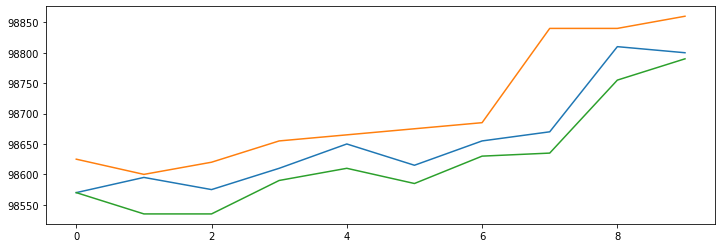

In [50]:
plot_sample(0,data_frame)

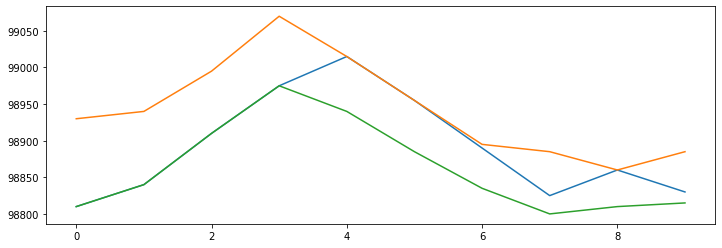

In [49]:
plot_sample(1,data_frame)

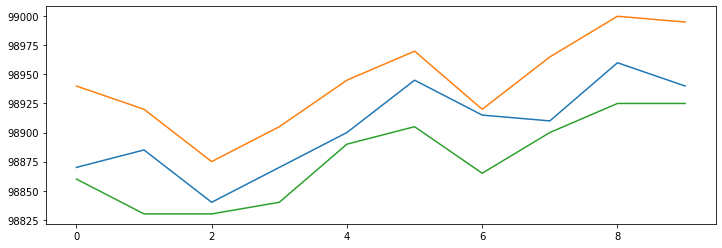

In [51]:
plot_sample(2,data_frame)

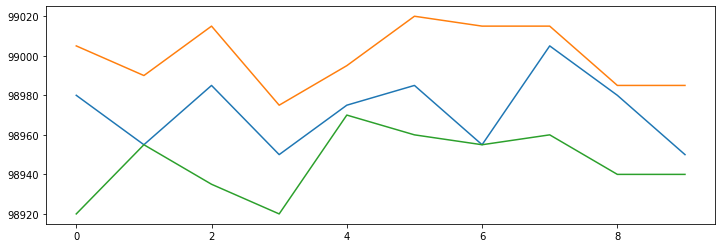

In [52]:
plot_sample(3,data_frame)

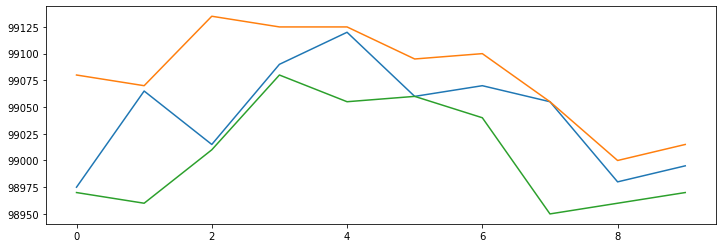

In [53]:
plot_sample(4,data_frame)

In [108]:
sequencias = np.empty()
labels = 

for x in range(len(data_frame.ID.unique())-1):
  sequencias.append(data_frame.loc[lambda data_frame: data_frame["ID"] == x, FEATURES])
  labels.append(data_frame.loc[(x+1)*10, 'Subiu'])

In [109]:
len(sequencias)

12958

In [114]:
sequencias[:20]

[   <OPEN>  <HIGH>  <LOW>
 0   98570   98625  98570
 1   98595   98600  98535
 2   98575   98620  98535
 3   98610   98655  98590
 4   98650   98665  98610
 5   98615   98675  98585
 6   98655   98685  98630
 7   98670   98840  98635
 8   98810   98840  98755
 9   98800   98860  98790,     <OPEN>  <HIGH>  <LOW>
 10   98810   98930  98810
 11   98840   98940  98840
 12   98910   98995  98910
 13   98975   99070  98975
 14   99015   99015  98940
 15   98955   98955  98885
 16   98890   98895  98835
 17   98825   98885  98800
 18   98860   98860  98810
 19   98830   98885  98815,     <OPEN>  <HIGH>  <LOW>
 20   98870   98940  98860
 21   98885   98920  98830
 22   98840   98875  98830
 23   98870   98905  98840
 24   98900   98945  98890
 25   98945   98970  98905
 26   98915   98920  98865
 27   98910   98965  98900
 28   98960   99000  98925
 29   98940   98995  98925,     <OPEN>  <HIGH>  <LOW>
 30   98980   99005  98920
 31   98955   98990  98955
 32   98985   99015  98935
 33   98950 

In [110]:
len(labels)

12958

In [111]:
split_frac = 0.8

split_idx = int(len(sequencias)*split_frac)
train_x, remaining_x = sequencias[:split_idx], sequencias[split_idx:]
train_y, remaining_y = labels[:split_idx], labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:


AttributeError: ignored

In [95]:
# Fazer dataloader
batch_size = 30

loader_treino = torch.utils.data.DataLoader(ds_treino, batch_size= batch_size,
                                            shuffle= True)
loader_validacao = torch.utils.data.DataLoader(ds_validacao, batch_size= batch_size,
                                            shuffle= True)
loader_teste = torch.utils.data.DataLoader(ds_teste, batch_size= batch_size,
                                            shuffle= True)

In [104]:
dataiter = iter(loader_treino)
dados, labels = dataiter.next()


TypeError: ignored

In [ ]:
from torch import nn
import torch.nn.functional as F

In [ ]:
tem_gpu = torch.cuda.is_available()

if not tem_gpu:
  print("Treinaremos na CPU")
else:
  print("Treinaremos da GPU")

In [ ]:
import torch.nn as nn

class Modelo_RNN(nn.Module):

    def __init__(self, n_features, output_size, hidden_dim, n_layers, 
                 drop_prob=0.5):
      
        super(Modelo_RNN, self).__init__()
        
        self.input_size = n_features
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        self.dropout = nn.Dropout(0.3)
        

        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        batch_size = x.size(0)

        # embeddings and lstm_out
        x = x.long()
        
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out[:, -1, :] # getting the last time step output
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sig(out)

        
        # return last sigmoid output and hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (tem_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden